<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/Land-Cover-Classification/blob/main/Land_Cover_Classification_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KLASIFIKASI TUTUPAN LAHAN BERDASARKAN SNI 7645-2010 PADA CITRA SATELIT MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK(CNN)**

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image. Selain itu, penelitian ini juga berasosiasi dengan Identifikasi Lahan Pertanian yang dilakukan oleh Fendy Prayogi dalam mengidentifikasi daerah sawah dan non-sawah menggunakan klasifikasi CNN.

Penelitian ini akan mengklasifikasikan citra satelit berdasarkan SNI 7645-2010 hingga tujuh kelas yang berbeda menggunakan CNN serta sliding window. 

Peneliti : Dhiemas Fatah Mujahid

Repositori tersedia pada : https://github.com/Soedirman-Machine-Learning/Land-Cover-Classification


# Mengimpor/Mengambil Fungsi Library

In [ ]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



# Mengambil Dataset dari Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Google Drive

!ls /content/drive/MyDrive/LCC/train
#gambar dengan label "s" adalah gambar dari fitur sawah(Kelas 0)"
#gambar dengan label "w"dan "k" adalah gambar dari fitur kebun sawit dan hutan(Kelas 1)"
#gambar dengan label "k" adalah gambar dari fitur kebun teh (Kelas 2)"
#gambar dengan label "t" adalah gambar dari fitur tambang (Kelas 3)"
#gambar dengan label "p" adalah gambar dari fitur pemukiman (Kelas 4)"
#gambar dengan label "a" adalah gambar berfitur danau (Kelas 5)"

a10.jpg  a2.jpg   h5.jpg   k21.jpg  p14.jpg  p6.jpg   s22.jpg  t15.jpg	t7.jpg
a11.jpg  a3.jpg   h6.jpg   k22.jpg  p17.jpg  p7.jpg   s23.jpg  t16.jpg	t8.jpg
a12.jpg  a4.jpg   h7.jpg   k23.jpg  p18.jpg  p8.jpg   s24.jpg  t17.jpg	t9.jpg
a13.jpg  a5.jpg   h8.jpg   k24.jpg  p19.jpg  p9.jpg   s25.jpg  t18.jpg	w10.jpg
a14.jpg  a6.jpg   h9.jpg   k25.jpg  p1.jpg   s10.jpg  s2.jpg   t19.jpg	w11.jpg
a15.jpg  a7.jpg   k10.jpg  k2.jpg   p20.jpg  s11.jpg  s3.jpg   t1.jpg	w12.jpg
a16.jpg  a8.jpg   k11.jpg  k3.jpg   p21.jpg  s12.jpg  s4.jpg   t20.jpg	w1.jpg
a17.jpg  a9.jpg   k12.jpg  k4.jpg   p23.jpg  s13.jpg  s5.jpg   t21.jpg	w2.jpg
a18.jpg  chopped  k13.jpg  k5.jpg   p24.jpg  s14.jpg  s6.jpg   t22.jpg	w3.jpg
a19.jpg  h10.jpg  k14.jpg  k6.jpg   p25.jpg  s15.jpg  s7.jpg   t23.jpg	w4.jpg
a1.jpg	 h11.jpg  k15.jpg  k7.jpg   p26.jpg  s16.jpg  s8.jpg   t24.jpg	w5.jpg
a20.jpg  h12.jpg  k16.jpg  k8.jpg   p27.jpg  s17.jpg  s9.jpg   t25.jpg	w6.jpg
a21.jpg  h13.jpg  k17.jpg  k9.jpg   p28.jpg  s18.jpg  t10.jpg  

#Menampilkan Gambar Pelatihan

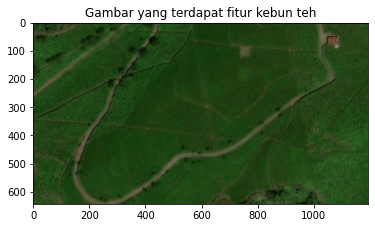

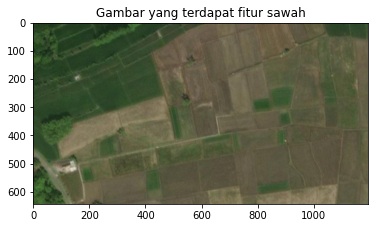

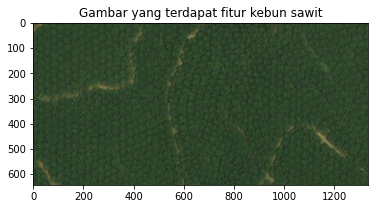

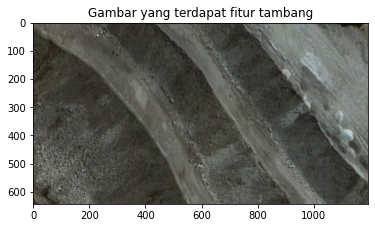

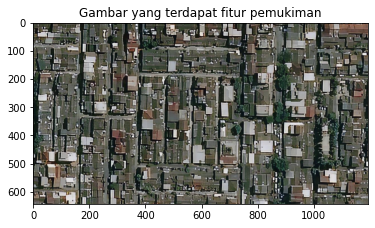

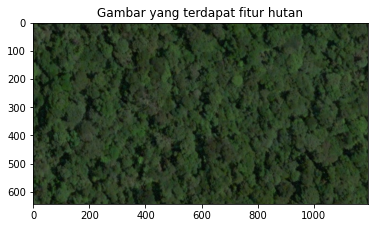

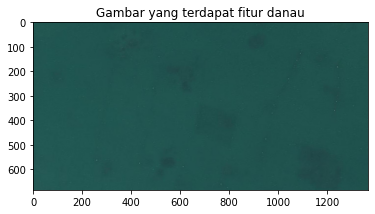

In [ ]:
#Gambar yang terdapat fitur kebun teh
plt.title("Gambar yang terdapat fitur kebun teh")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/k12.jpg"))
plt.show()

#Gambar yang terdapat fitur sawah
plt.title("Gambar yang terdapat fitur sawah")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/s2.jpg"))
plt.show()

#Gambar yang terdapat fitur kebun sawit
plt.title("Gambar yang terdapat fitur kebun sawit")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/w4.jpg"))
plt.show()

#Gambar yang terdapat fitur tambang
plt.title("Gambar yang terdapat fitur tambang")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/t15.jpg"))
plt.show()

#Gambar yang terdapat fitur pemukiman
plt.title("Gambar yang terdapat fitur pemukiman")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/p3.jpg"))
plt.show()

#Gambar yang terdapat fitur hutan
plt.title("Gambar yang terdapat fitur hutan")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/h5.jpg"))
plt.show()

#Gambar yang terdapat fitur danau
plt.title("Gambar yang terdapat fitur danau")
plt.imshow(imread("/content/drive/MyDrive/LCC/train/a7.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 




In [ ]:
#Sliding Window Batch 1
def save_to_folder(img_path,directory,size=56,overlap=0.1):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img, check_contrast=False)

files = os.listdir("/content/drive/MyDrive/LCC/train")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "/content/drive/MyDrive/LCC/train/chopped"
    file = os.path.join("/content/drive/MyDrive/LCC/train",file)
    save_to_folder(file,save_directory)

# Dataset Pelatihan

Dataset yang digunakan dalam Model Performa Klasifikasi akurasi, Recall Rate dan Presisi. Data pelatihan yang telah dichop sehingga menghasilkan gambar baru, lalu kita klasifikasikan hasilnya dengan empat kategori berupa :  *true positive* (TP), *false positive* (FP), *false negative* (FN), dan *true negative* (TN). 
Dengan ketentuan prediksi benar atau salah dan gambar sesuai dengan kelas masing-masing diberi label kelasnya

In [ ]:
#Array Dataset Batch 1
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Mengambil citra dataset yang telah dipotong
files = os.listdir("/content/drive/MyDrive/LCC/train/chopped")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan dalam bentuk array
x = []
y = []

for file in files:
    if file.startswith("s"):
        label = [1,0,0,0,0,0]
    elif file.startswith("w"):
        label = [0,1,0,0,0,0]
    elif file.startswith("h"):
        label = [0,1,0,0,0,0]
    elif file.startswith("k"):
        label = [0,0,1,0,0,0]
    elif file.startswith("t"):
        label = [0,0,0,1,0,0]
    elif file.startswith("p"):
        label = [0,0,0,0,1,0]
    elif file.startswith("a"):
        label = [0,0,0,0,0,1]
    
    img_path = os.path.join("/content/drive/MyDrive/LCC/train/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

X1 = np.array(x)
Y1 = np.array(y)
print("Bentuk array dari dataset train (pelatihan) adalah :", (X1.shape,Y1.shape))

Bentuk array dari dataset train (pelatihan) adalah : ((48972, 56, 56, 3), (48972, 6))


In [ ]:
np.save("X1.npy",X1)
np.save("Y1.npy",Y1)

**Persiapan Data Testing**

In [ ]:
#Sliding Window Batch 1
def save_to_folder(img_path,directory,size=56,overlap=0.1):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img, check_contrast=False)

files = os.listdir("/content/drive/MyDrive/LCC/testing")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "/content/drive/MyDrive/LCC/testing/potong"
    file = os.path.join("/content/drive/MyDrive/LCC/testing",file)
    save_to_folder(file,save_directory)

In [ ]:
#Array Dataset Batch 1
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Mengambil citra testing yang telah dipotong
files = os.listdir("/content/drive/MyDrive/LCC/testing/potong")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan dalam bentuk array
x = []
y = []

for file in files:
    if file.startswith("s"):
        label = [1,0,0,0,0,0]
    elif file.startswith("w"):
        label = [0,1,0,0,0,0]
    elif file.startswith("h"):
        label = [0,1,0,0,0,0]
    elif file.startswith("k"):
        label = [0,0,1,0,0,0]
    elif file.startswith("t"):
        label = [0,0,0,1,0,0]
    elif file.startswith("p"):
        label = [0,0,0,0,1,0]
    elif file.startswith("a"):
        label = [0,0,0,0,0,1]
    
    img_path = os.path.join("/content/drive/MyDrive/LCC/testing/potong",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

X1_test = np.array(x)
Y1_test = np.array(y)
print("Bentuk array dari dataset train (pelatihan) adalah :", (X1_test.shape,Y1_test.shape))

Bentuk array dari dataset train (pelatihan) adalah : ((113154, 56, 56, 3), (113154, 6))


In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(X1,
                                                      Y1,
                                                      test_size=0.15,
                                                      stratify = Y1)

print("Bentuk array dari dataset train (pelatihan) adalah:",train_x.shape,train_x.shape)
print("Bentuk array dari dataset validation adalah:",valid_x.shape,valid_x.shape)
#print("Bentuk array dari dataset test (pengujian) adalah:",x_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (41626, 56, 56, 3) (41626, 56, 56, 3)
Bentuk array dari dataset validation adalah: (7346, 56, 56, 3) (7346, 56, 56, 3)


#Pembuatan Model

In [ ]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd


In [ ]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.Sequential([
    base_model,  
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(224,224,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(16,(3,3),name="conv4",padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(16,(3,3),name="conv5",padding="same"),
    tf.keras.layers.Flatten(),
    #layers.Dropout(0.05),
    tf.keras.layers.Dense(6,activation = tf.keras.activations.softmax)]
    )

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 conv1 (Conv2D)              (None, 2, 2, 16)          294928    
                                                                 
 conv2 (Conv2D)              (None, 2, 2, 32)          4640      
                                                                 
 activation (Activation)     (None, 2, 2, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 2, 2, 32)          9248      
                                                                 
 activation_1 (Activation)   (None, 2, 2, 32)          0         
                                                                 
 conv4 (Conv2D)              (None, 2, 2, 16)          4

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("/content/drive/MyDrive/LCC/resnet/aset/test_chop.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history= model.fit(train_x,
                    train_y,
                    batch_size=100,
                    epochs = 55,
                    validation_data=(valid_x,valid_y),
                    callbacks = [ckpt]
                    )

Epoch 1/55
417/417 [==============================] - ETA: 0s - loss: 0.0599 - acc: 0.9392
Epoch 1: val_loss improved from inf to 0.03019, saving model to /content/drive/MyDrive/LCC/resnet/aset/test_chop.h5
417/417 [==============================] - 135s 263ms/step - loss: 0.0599 - acc: 0.9392 - val_loss: 0.0302 - val_acc: 0.9715
Epoch 2/55
417/417 [==============================] - ETA: 0s - loss: 0.0218 - acc: 0.9801
Epoch 2: val_loss did not improve from 0.03019
417/417 [==============================] - 99s 238ms/step - loss: 0.0218 - acc: 0.9801 - val_loss: 0.3352 - val_acc: 0.8038
Epoch 3/55
417/417 [==============================] - ETA: 0s - loss: 0.0264 - acc: 0.9757
Epoch 3: val_loss did not improve from 0.03019
417/417 [==============================] - 99s 238ms/step - loss: 0.0264 - acc: 0.9757 - val_loss: 0.3971 - val_acc: 0.7920
Epoch 4/55
417/417 [==============================] - ETA: 0s - loss: 0.0204 - acc: 0.9823
Epoch 4: val_loss did not improve from 0.03019
417/41

#Menggambarkan Hasil Pelatihan

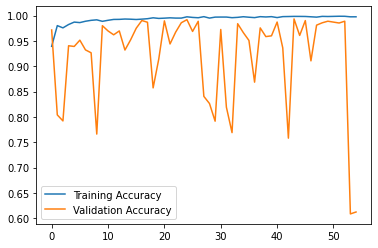

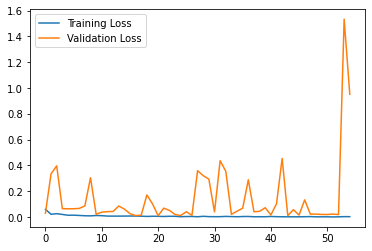

In [ ]:
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

# Evaluasi dengan model


In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/LCC/resnet/aset/resnetu.h5")

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_x,train_y))

#Evaluasi validasi data
print(model.evaluate(valid_x,valid_y))

['loss', 'acc']
1301/1301 [==============================] - 53s 40ms/step - loss: 0.9100 - acc: 0.6147
[0.909956157207489, 0.6146638989448547]


In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data testing
print(model.evaluate(X1_test,Y1_test))

['loss', 'acc']
3537/3537 [==============================] - 65s 16ms/step - loss: 0.1447 - acc: 0.9214
[0.14472147822380066, 0.9214433431625366]


#Matriks Evaluasi Deep Learning

## Validasi

In [ ]:
y_pred_class =np.argmax(model.predict(x = valid_x), axis=-1)
y_pred_class.shape

(8592,)

In [ ]:
y_true_valid = []
for i in valid_y:
    y_true_valid.append(np.argmax(i))

In [ ]:
#Klasifikasi Multi Kelas
from sklearn.metrics import classification_report

print(classification_report(y_true_valid, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1281
           1       0.99      1.00      1.00      2486
           2       0.98      0.98      0.98      1145
           3       0.99      0.99      0.99      1170
           4       1.00      0.99      0.99      1205
           5       1.00      0.99      1.00      1305

    accuracy                           0.99      8592
   macro avg       0.99      0.99      0.99      8592
weighted avg       0.99      0.99      0.99      8592



### Confusion Matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix_valid = confusion_matrix(y_true_valid, y_pred_class)
print(cf_matrix_valid)

[[1257    1   17    6    0    0]
 [   0 2485    1    0    0    0]
 [   8   13 1122    1    1    0]
 [   3    0    0 1164    3    0]
 [   1    0    0    5 1198    1]
 [   0    0    6    0    2 1297]]


In [ ]:
nrml_cf = np.zeros((6,6))
row_sums = cf_matrix_valid.sum(axis=1)
for i in range(len(cf_matrix_valid)):
  for j in range(len(cf_matrix_valid)):
    nrml_cf[i][j] = cf_matrix_valid[i][j] / row_sums[i]

In [ ]:
  np.around(nrml_cf, decimals = 3)

array([[0.981, 0.001, 0.013, 0.005, 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.007, 0.011, 0.98 , 0.001, 0.001, 0.   ],
       [0.003, 0.   , 0.   , 0.995, 0.003, 0.   ],
       [0.001, 0.   , 0.   , 0.004, 0.994, 0.001],
       [0.   , 0.   , 0.005, 0.   , 0.002, 0.994]])

In [ ]:
#KOMPUTASI TP,TN,FP,FN

#Kelas 0
TP0 = cf_matrix_valid[0,0]
TN01 = cf_matrix_valid[1,1] + cf_matrix_valid[1,2] + cf_matrix_valid[1,3] + cf_matrix_valid[1,4] + cf_matrix_valid[1,5]
TN02 = cf_matrix_valid[2,1] + cf_matrix_valid[2,2] + cf_matrix_valid[2,3] + cf_matrix_valid[2,4] + cf_matrix_valid[2,5]
TN03 = cf_matrix_valid[3,1] + cf_matrix_valid[3,2] + cf_matrix_valid[3,3] + cf_matrix_valid[3,4] + cf_matrix_valid[3,5]
TN04 = cf_matrix_valid[4,1] + cf_matrix_valid[4,2] + cf_matrix_valid[4,3] + cf_matrix_valid[4,4] + cf_matrix_valid[4,5]
TN05 = cf_matrix_valid[5,1] + cf_matrix_valid[5,2] + cf_matrix_valid[5,3] + cf_matrix_valid[5,4] + cf_matrix_valid[5,5]
TN0 = TN01 + TN02 + TN03 + TN04 + TN05
FP0 = cf_matrix_valid[0,1] + cf_matrix_valid[0,2] + cf_matrix_valid[0,3] + cf_matrix_valid[0,4] + cf_matrix_valid[0,5]
FN0 = cf_matrix_valid[1,0] + cf_matrix_valid[2,0] + cf_matrix_valid[3,0] + cf_matrix_valid[4,0] + cf_matrix_valid[5,0]

#KELAS 1
TP1 = cf_matrix_valid[1,1]
TN10 = cf_matrix_valid[0,0] + cf_matrix_valid[0,2] + cf_matrix_valid[0,3] + cf_matrix_valid[0,4] + cf_matrix_valid[0,5]
TN12 = cf_matrix_valid[2,0] + cf_matrix_valid[2,2] + cf_matrix_valid[2,3] + cf_matrix_valid[2,4] + cf_matrix_valid[2,5]
TN13 = cf_matrix_valid[3,0] + cf_matrix_valid[3,2] + cf_matrix_valid[3,3] + cf_matrix_valid[3,4] + cf_matrix_valid[3,5]
TN14 = cf_matrix_valid[4,0] + cf_matrix_valid[4,2] + cf_matrix_valid[4,3] + cf_matrix_valid[4,4] + cf_matrix_valid[4,5]
TN15 = cf_matrix_valid[5,0] + cf_matrix_valid[5,2] + cf_matrix_valid[5,3] + cf_matrix_valid[5,4] + cf_matrix_valid[5,5]
TN1 = TN10 + TN12 + TN13 + TN14 + TN15
FP1 = cf_matrix_valid[1,0] + cf_matrix_valid[1,2] + cf_matrix_valid[1,3] + cf_matrix_valid[1,4] + cf_matrix_valid[1,5]
FN1 = cf_matrix_valid[0,1] + cf_matrix_valid[2,1] + cf_matrix_valid[3,1] + cf_matrix_valid[4,1] + cf_matrix_valid[5,1]

#KELAS 2

TP2 = cf_matrix_valid[2,2]
TN20 = cf_matrix_valid[0,0] + cf_matrix_valid[0,1] + cf_matrix_valid[0,3] + cf_matrix_valid[0,4] + cf_matrix_valid[0,5]
TN21 = cf_matrix_valid[1,0] + cf_matrix_valid[1,1] + cf_matrix_valid[1,3] + cf_matrix_valid[1,4] + cf_matrix_valid[1,5]
TN23 = cf_matrix_valid[3,0] + cf_matrix_valid[3,1] + cf_matrix_valid[3,3] + cf_matrix_valid[3,4] + cf_matrix_valid[3,5]
TN24 = cf_matrix_valid[4,0] + cf_matrix_valid[4,1] + cf_matrix_valid[4,3] + cf_matrix_valid[4,4] + cf_matrix_valid[4,5]
TN25 = cf_matrix_valid[5,0] + cf_matrix_valid[5,1] + cf_matrix_valid[5,3] + cf_matrix_valid[5,4] + cf_matrix_valid[5,5]
TN2 = TN20 + TN21 + TN23 + TN24 + TN25
FP2 = cf_matrix_valid[2,0] + cf_matrix_valid[2,1] + cf_matrix_valid[2,3] + cf_matrix_valid[2,4] + cf_matrix_valid[2,5]
FN2 = cf_matrix_valid[0,2] + cf_matrix_valid[1,2] + cf_matrix_valid[3,2] + cf_matrix_valid[4,2] + cf_matrix_valid[5,2]

#KELAS 3
TP3 = cf_matrix_valid[3,3]
TN30 = cf_matrix_valid[0,0] + cf_matrix_valid[0,1] + cf_matrix_valid[0,2] + cf_matrix_valid[0,4] + cf_matrix_valid[0,5]
TN31 = cf_matrix_valid[1,0] + cf_matrix_valid[1,1] + cf_matrix_valid[1,2] + cf_matrix_valid[1,4] + cf_matrix_valid[1,5]
TN32 = cf_matrix_valid[2,0] + cf_matrix_valid[2,1] + cf_matrix_valid[2,2] + cf_matrix_valid[2,4] + cf_matrix_valid[2,5]
TN34 = cf_matrix_valid[4,0] + cf_matrix_valid[4,1] + cf_matrix_valid[4,2] + cf_matrix_valid[4,4] + cf_matrix_valid[4,5]
TN35 = cf_matrix_valid[5,0] + cf_matrix_valid[5,1] + cf_matrix_valid[5,2] + cf_matrix_valid[5,4] + cf_matrix_valid[5,5]
TN3 = TN30 + TN31 + TN32 + TN34 + TN35
FP3 = cf_matrix_valid[3,0] + cf_matrix_valid[3,1] + cf_matrix_valid[3,2] + cf_matrix_valid[3,4] + cf_matrix_valid[3,5]
FN3 = cf_matrix_valid[0,3] + cf_matrix_valid[1,3] + cf_matrix_valid[2,3] + cf_matrix_valid[4,3] + cf_matrix_valid[5,3]

#KELAS 4
TP4 = cf_matrix_valid[4,4]
TN40 = cf_matrix_valid[0,0] + cf_matrix_valid[0,1] + cf_matrix_valid[0,2] + cf_matrix_valid[0,3] + cf_matrix_valid[0,5]
TN41 = cf_matrix_valid[1,0] + cf_matrix_valid[1,1] + cf_matrix_valid[1,2] + cf_matrix_valid[1,3] + cf_matrix_valid[1,5]
TN42 = cf_matrix_valid[2,0] + cf_matrix_valid[2,1] + cf_matrix_valid[2,2] + cf_matrix_valid[2,3] + cf_matrix_valid[2,5]
TN43 = cf_matrix_valid[3,0] + cf_matrix_valid[3,1] + cf_matrix_valid[3,2] + cf_matrix_valid[3,3] + cf_matrix_valid[3,5]
TN45 = cf_matrix_valid[5,0] + cf_matrix_valid[5,1] + cf_matrix_valid[5,2] + cf_matrix_valid[5,3] + cf_matrix_valid[5,5]
TN4 = TN40 + TN41 + TN42 + TN43 + TN45
FP4 = cf_matrix_valid[4,0] + cf_matrix_valid[4,1] + cf_matrix_valid[4,2] + cf_matrix_valid[4,3] + cf_matrix_valid[4,5]
FN4 = cf_matrix_valid[0,4] + cf_matrix_valid[1,4] + cf_matrix_valid[2,4] + cf_matrix_valid[3,4] + cf_matrix_valid[5,4] 

#KELAS 5
TP5 = cf_matrix_valid[5,5]
TN50 = cf_matrix_valid[0,0] + cf_matrix_valid[0,1] + cf_matrix_valid[0,2] + cf_matrix_valid[0,3] + cf_matrix_valid[0,4]
TN51 = cf_matrix_valid[1,0] + cf_matrix_valid[1,1] + cf_matrix_valid[1,2] + cf_matrix_valid[1,3] + cf_matrix_valid[1,4]
TN52 = cf_matrix_valid[2,0] + cf_matrix_valid[2,1] + cf_matrix_valid[2,2] + cf_matrix_valid[2,3] + cf_matrix_valid[2,4]
TN53 = cf_matrix_valid[3,0] + cf_matrix_valid[3,1] + cf_matrix_valid[3,2] + cf_matrix_valid[3,3] + cf_matrix_valid[3,4]
TN54 = cf_matrix_valid[4,0] + cf_matrix_valid[4,1] + cf_matrix_valid[4,2] + cf_matrix_valid[4,3] + cf_matrix_valid[4,4]
TN5 = TN50 + TN51 + TN52 + TN53 + TN54
FP5 = cf_matrix_valid[5,0] + cf_matrix_valid[5,1] + cf_matrix_valid[5,2] + cf_matrix_valid[5,3] + cf_matrix_valid[5,4]
FN5 = cf_matrix_valid[0,5] + cf_matrix_valid[1,5] + cf_matrix_valid[2,5] + cf_matrix_valid[3,5] + cf_matrix_valid[4,5]



### Parameter Unjuk Kerja Deep Learning Pada Validasi

In [ ]:
#Parameter Kelas 0
Akurasi0 = (TP0 + TN0)/(TP0+TN0+FP0+FN0)
Error0 = (FP0+FN0)/(TP0+TN0+FP0+FN0)
Presisi0 = TP0/(TP0+FP0)
Recall0 = TP0/(TP0+FN0)
F1_Score0 = (2*TP0)/((2*TP0)+FP0+FN0)
print("Nilai parameter kelas 0 :\n Akurasi =", Akurasi0)
print("\n")
print(" Error = ", Error0)
print("\n")
print(" Presisi = ",Presisi0)
print("\n")
print(" Recall = ",Recall0)
print("\n")
print(" F1_Score = ",F1_Score0)
print("\n")
print("\n")
#Parameter Kelas 1
Akurasi1 = (TP1 + TN1)/(TP1+TN1+FP1+FN1)
Error1 = (FP1+FN1)/(TP1+TN1+FP1+FN1)
Presisi1 = TP1/(TP1+FP1)
Recall1 = TP1/(TP1+FN1)
F1_Score1 = (2*TP1)/((2*TP1)+FP1+FN1)
print("Nilai parameter kelas 1 :\n Akurasi =", Akurasi1)
print("\n")
print(" Error = ", Error1)
print("\n")
print(" Presisi = ",Presisi1)
print("\n")
print(" Recall = ",Recall1)
print("\n")
print(" F1_Score = ",F1_Score1)
print("\n")
print("\n")
#Parameter Kelas 2
Akurasi2 = (TP2 + TN2)/(TP2+TN2+FP2+FN2)
Error2 = (FP2+FN2)/(TP2+TN2+FP2+FN2)
Presisi2 = TP2/(TP2+FP2)
Recall2 = TP2/(TP2+FN2)
F1_Score2 = (2*TP2)/((2*TP2)+FP2+FN2)
print("Nilai parameter kelas 2 :\n Akurasi =", Akurasi2)
print("\n")
print(" Error = ", Error2)
print("\n")
print(" Presisi = ",Presisi2)
print("\n")
print(" Recall = ",Recall2)
print("\n")
print(" F1_Score = ",F1_Score2)
print("\n")
print("\n")
#Parameter Kelas 3
Akurasi3 = (TP3 + TN3)/(TP3+TN3+FP3+FN3)
Error3 = (FP3+FN3)/(TP3+TN3+FP3+FN3)
Presisi3 = TP3/(TP3+FP3)
Recall3 = TP3/(TP3+FN3)
F1_Score3 = (2*TP3)/((2*TP3)+FP3+FN3)
print("Nilai parameter kelas 3 :\n Akurasi =", Akurasi3)
print("\n")
print(" Error = ", Error3)
print("\n")
print(" Presisi = ",Presisi3)
print("\n")
print(" Recall = ",Recall3)
print("\n")
print(" F1_Score = ",F1_Score3)
print("\n")
print("\n")
#Parameter Kelas 4
Akurasi4 = (TP4 + TN4)/(TP4+TN4+FP4+FN4)
Error4 = (FP4+FN4)/(TP4+TN4+FP4+FN4)
Presisi4 = TP4/(TP4+FP4)
Recall4 = TP4/(TP4+FN4)
F1_Score4 = (2*TP4)/((2*TP4)+FP4+FN4)
print("Nilai parameter kelas 4 :\n Akurasi =", Akurasi4)
print("\n")
print(" Error = ", Error4)
print("\n")
print(" Presisi = ",Presisi4)
print("\n")
print(" Recall = ",Recall4)
print("\n")
print(" F1_Score = ",F1_Score4)
print("\n")
print("\n")
#Parameter Kelas 5
Akurasi5 = (TP5 + TN5)/(TP5+TN5+FP5+FN5)
Error5 = (FP5+FN5)/(TP5+TN5+FP5+FN5)
Presisi5 = TP5/(TP5+FP5)
Recall5 = TP5/(TP5+FN5)
F1_Score5 = (2*TP5)/((2*TP5)+FP5+FN5)
print("Nilai parameter kelas 5 :\n Akurasi =", Akurasi5)
print("\n")
print(" Error = ", Error5)
print("\n")
print(" Presisi = ",Presisi5)
print("\n")
print(" Recall = ",Recall5)
print("\n")
print(" F1_Score = ",F1_Score5)
print("\n")
print("\n")

Nilai parameter kelas 0 :
 Akurasi = 0.9958100558659218


 Error =  0.004189944134078212


 Presisi =  0.9812646370023419


 Recall =  0.9905437352245863


 F1_Score =  0.9858823529411764




Nilai parameter kelas 1 :
 Akurasi = 0.9982541899441341


 Error =  0.0017458100558659217


 Presisi =  0.999597747385358


 Recall =  0.9943977591036415


 F1_Score =  0.9969909729187563




Nilai parameter kelas 2 :
 Akurasi = 0.9945297951582868


 Error =  0.005470204841713222


 Presisi =  0.9799126637554585


 Recall =  0.9790575916230366


 F1_Score =  0.9794849410737669




Nilai parameter kelas 3 :
 Akurasi = 0.9979050279329609


 Error =  0.002094972067039106


 Presisi =  0.9948717948717949


 Recall =  0.9897959183673469


 F1_Score =  0.9923273657289002




Nilai parameter kelas 4 :
 Akurasi = 0.9984869646182495


 Error =  0.0015130353817504655


 Presisi =  0.9941908713692946


 Recall =  0.9950166112956811


 F1_Score =  0.9946035699460357




Nilai parameter kelas 5 :
 Akurasi = 0.

## Testing

In [ ]:
y_pred_class =np.argmax(model.predict(x = X1_test), axis=-1)
y_pred_class.shape

(113154,)

In [ ]:
y_true = []
for i in Y1_test:
    y_true.append(np.argmax(i))

In [ ]:
#Klasifikasi Multi Kelas
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     17277
           1       0.99      0.87      0.92     32864
           2       0.95      0.96      0.95     15080
           3       0.90      0.91      0.90     15600
           4       0.79      0.94      0.86     16172
           5       0.99      0.92      0.95     16161

    accuracy                           0.92    113154
   macro avg       0.92      0.93      0.92    113154
weighted avg       0.93      0.92      0.92    113154



### Confusion Matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix_test = confusion_matrix(y_true, y_pred_class)
print(cf_matrix_test)

[[16964    11   223    61     0    18]
 [   17 28474   386    19  3941    27]
 [  243   216 14512    15    41    53]
 [ 1279    11    48 14212    46     4]
 [  293   113   145   342 15189    90]
 [    0     0     0  1195    52 14914]]


In [ ]:
nrml_cf = np.zeros((6,6))
row_sums = cf_matrix_test.sum(axis=1)
for i in range(len(cf_matrix_test)):
  for j in range(len(cf_matrix_test)):
    nrml_cf[i][j] = cf_matrix_test[i][j] / row_sums[i]

In [ ]:
np.around(nrml_cf, decimals = 3)

array([[0.982, 0.001, 0.013, 0.004, 0.   , 0.001],
       [0.001, 0.866, 0.012, 0.001, 0.12 , 0.001],
       [0.016, 0.014, 0.962, 0.001, 0.003, 0.004],
       [0.082, 0.001, 0.003, 0.911, 0.003, 0.   ],
       [0.018, 0.007, 0.009, 0.021, 0.939, 0.006],
       [0.   , 0.   , 0.   , 0.074, 0.003, 0.923]])

In [ ]:
#KOMPUTASI TP,TN,FP,FN

#Kelas 0
TP0 = cf_matrix_test[0,0]
TN01 = cf_matrix_test[1,1] + cf_matrix_test[1,2] + cf_matrix_test[1,3] + cf_matrix_test[1,4] + cf_matrix_test[1,5]
TN02 = cf_matrix_test[2,1] + cf_matrix_test[2,2] + cf_matrix_test[2,3] + cf_matrix_test[2,4] + cf_matrix_test[2,5]
TN03 = cf_matrix_test[3,1] + cf_matrix_test[3,2] + cf_matrix_test[3,3] + cf_matrix_test[3,4] + cf_matrix_test[3,5]
TN04 = cf_matrix_test[4,1] + cf_matrix_test[4,2] + cf_matrix_test[4,3] + cf_matrix_test[4,4] + cf_matrix_test[4,5]
TN05 = cf_matrix_test[5,1] + cf_matrix_test[5,2] + cf_matrix_test[5,3] + cf_matrix_test[5,4] + cf_matrix_test[5,5]
TN0 = TN01 + TN02 + TN03 + TN04 + TN05
FP0 = cf_matrix_test[0,1] + cf_matrix_test[0,2] + cf_matrix_test[0,3] + cf_matrix_test[0,4] + cf_matrix_test[0,5]
FN0 = cf_matrix_test[1,0] + cf_matrix_test[2,0] + cf_matrix_test[3,0] + cf_matrix_test[4,0] + cf_matrix_test[5,0]

#KELAS 1
TP1 = cf_matrix_test[1,1]
TN10 = cf_matrix_test[0,0] + cf_matrix_test[0,2] + cf_matrix_test[0,3] + cf_matrix_test[0,4] + cf_matrix_test[0,5]
TN12 = cf_matrix_test[2,0] + cf_matrix_test[2,2] + cf_matrix_test[2,3] + cf_matrix_test[2,4] + cf_matrix_test[2,5]
TN13 = cf_matrix_test[3,0] + cf_matrix_test[3,2] + cf_matrix_test[3,3] + cf_matrix_test[3,4] + cf_matrix_test[3,5]
TN14 = cf_matrix_test[4,0] + cf_matrix_test[4,2] + cf_matrix_test[4,3] + cf_matrix_test[4,4] + cf_matrix_test[4,5]
TN15 = cf_matrix_test[5,0] + cf_matrix_test[5,2] + cf_matrix_test[5,3] + cf_matrix_test[5,4] + cf_matrix_test[5,5]
TN1 = TN10 + TN12 + TN13 + TN14 + TN15
FP1 = cf_matrix_test[1,0] + cf_matrix_test[1,2] + cf_matrix_test[1,3] + cf_matrix_test[1,4] + cf_matrix_test[1,5]
FN1 = cf_matrix_test[0,1] + cf_matrix_test[2,1] + cf_matrix_test[3,1] + cf_matrix_test[4,1] + cf_matrix_test[5,1]

#KELAS 2

TP2 = cf_matrix_test[2,2]
TN20 = cf_matrix_test[0,0] + cf_matrix_test[0,1] + cf_matrix_test[0,3] + cf_matrix_test[0,4] + cf_matrix_test[0,5]
TN21 = cf_matrix_test[1,0] + cf_matrix_test[1,1] + cf_matrix_test[1,3] + cf_matrix_test[1,4] + cf_matrix_test[1,5] 
TN23 = cf_matrix_test[3,0] + cf_matrix_test[3,1] + cf_matrix_test[3,3] + cf_matrix_test[3,4] + cf_matrix_test[3,5]
TN24 = cf_matrix_test[4,0] + cf_matrix_test[4,1] + cf_matrix_test[4,3] + cf_matrix_test[4,4] + cf_matrix_test[4,5]
TN25 = cf_matrix_test[5,0] + cf_matrix_test[5,1] + cf_matrix_test[5,3] + cf_matrix_test[5,4] + cf_matrix_test[5,5]
TN2 = TN20 + TN21 + TN23 + TN24 + TN25
FP2 = cf_matrix_test[2,0] + cf_matrix_test[2,1] + cf_matrix_test[2,3] + cf_matrix_test[2,4] + cf_matrix_test[2,5]
FN2 = cf_matrix_test[0,2] + cf_matrix_test[1,2] + cf_matrix_test[3,2] + cf_matrix_test[4,2] + cf_matrix_test[5,2]

#KELAS 3
TP3 = cf_matrix_test[3,3]
TN30 = cf_matrix_test[0,0] + cf_matrix_test[0,1] + cf_matrix_test[0,2] + cf_matrix_test[0,4] + cf_matrix_test[0,5] 
TN31 = cf_matrix_test[1,0] + cf_matrix_test[1,1] + cf_matrix_test[1,2] + cf_matrix_test[1,4] + cf_matrix_test[1,5]
TN32 = cf_matrix_test[2,0] + cf_matrix_test[2,1] + cf_matrix_test[2,2] + cf_matrix_test[2,4] + cf_matrix_test[2,5]
TN34 = cf_matrix_test[4,0] + cf_matrix_test[4,1] + cf_matrix_test[4,2] + cf_matrix_test[4,4] + cf_matrix_test[4,5]
TN35 = cf_matrix_test[5,0] + cf_matrix_test[5,1] + cf_matrix_test[5,2] + cf_matrix_test[5,4] + cf_matrix_test[5,5]
TN3 = TN30 + TN31 + TN32 + TN34 + TN35
FP3 = cf_matrix_test[3,0] + cf_matrix_test[3,1] + cf_matrix_test[3,2] + cf_matrix_test[3,4] + cf_matrix_test[3,5]
FN3 = cf_matrix_test[0,3] + cf_matrix_test[1,3] + cf_matrix_test[2,3] + cf_matrix_test[4,3] + cf_matrix_test[5,3]

#KELAS 4
TP4 = cf_matrix_test[4,4]
TN40 = cf_matrix_test[0,0] + cf_matrix_test[0,1] + cf_matrix_test[0,2] + cf_matrix_test[0,3] + cf_matrix_test[0,5]
TN41 = cf_matrix_test[1,0] + cf_matrix_test[1,1] + cf_matrix_test[1,2] + cf_matrix_test[1,3] + cf_matrix_test[1,5] 
TN42 = cf_matrix_test[2,0] + cf_matrix_test[2,1] + cf_matrix_test[2,2] + cf_matrix_test[2,3] + cf_matrix_test[2,5]
TN43 = cf_matrix_test[3,0] + cf_matrix_test[3,1] + cf_matrix_test[3,2] + cf_matrix_test[3,3] + cf_matrix_test[3,5]
TN45 = cf_matrix_test[5,0] + cf_matrix_test[5,1] + cf_matrix_test[5,2] + cf_matrix_test[5,3] + cf_matrix_test[5,5]
TN4 = TN40 + TN41 + TN42 + TN43 + TN45
FP4 = cf_matrix_test[4,0] + cf_matrix_test[4,1] + cf_matrix_test[4,2] + cf_matrix_test[4,3] + cf_matrix_test[4,5]
FN4 = cf_matrix_test[0,4] + cf_matrix_test[1,4] + cf_matrix_test[2,4] + cf_matrix_test[3,4] + cf_matrix_test[5,4]

#KELAS 5
TP5 = cf_matrix_test[5,5]
TN50 = cf_matrix_test[0,0] + cf_matrix_test[0,1] + cf_matrix_test[0,2] + cf_matrix_test[0,3] + cf_matrix_test[0,4]
TN51 = cf_matrix_test[1,0] + cf_matrix_test[1,1] + cf_matrix_test[1,2] + cf_matrix_test[1,3] + cf_matrix_test[1,4]
TN52 = cf_matrix_test[2,0] + cf_matrix_test[2,1] + cf_matrix_test[2,2] + cf_matrix_test[2,3] + cf_matrix_test[2,4] 
TN53 = cf_matrix_test[3,0] + cf_matrix_test[3,1] + cf_matrix_test[3,2] + cf_matrix_test[3,3] + cf_matrix_test[3,4]
TN54 = cf_matrix_test[4,0] + cf_matrix_test[4,1] + cf_matrix_test[4,2] + cf_matrix_test[4,3] + cf_matrix_test[4,4]
TN5 = TN50 + TN51 + TN52 + TN53 + TN54
FP5 = cf_matrix_test[5,0] + cf_matrix_test[5,1] + cf_matrix_test[5,2] + cf_matrix_test[5,3] + cf_matrix_test[5,4]
FN5 = cf_matrix_test[0,5] + cf_matrix_test[1,5] + cf_matrix_test[2,5] + cf_matrix_test[3,5] + cf_matrix_test[4,5]


In [ ]:
print(TP0)
print(TP1)
print(TP2)
print(TP3)
print(TP4)
print(TP5)
print("\n")
print(TN0)
print(TN1)
print(TN2)
print(TN3)
print(TN4)
print(TN5)

16964
28474
14512
14212
15189
14914


94045
79939
97272
95922
92902
96801


In [ ]:
print(FP0)
print(FP1)
print(FP2)
print(FP3)
print(FP4)
print(FP5)
print("\n")
print(FN0)
print(FN1)
print(FN2)
print(FN3)
print(FN4)
print(FN5)

313
4390
568
1388
983
1247


1832
351
802
1632
4080
192


### Parameter Unjuk Kerja Deep Learning pada Testing

In [ ]:
#Parameter Kelas 0
Akurasi0 = (TP0 + TN0)/(TP0+TN0+FP0+FN0)
Error0 = (FP0+FN0)/(TP0+TN0+FP0+FN0)
Presisi0 = TP0/(TP0+FP0)
Recall0 = TP0/(TP0+FN0)
F1_Score0 = (2*TP0)/((2*TP0)+FP0+FN0)
print("Nilai parameter kelas 0 :\n Akurasi =", Akurasi0)
print("\n")
print(" Error = ", Error0)
print("\n")
print(" Presisi = ",Presisi0)
print("\n")
print(" Recall = ",Recall0)
print("\n")
print(" F1_Score = ",F1_Score0)
print("\n")
print("\n")
#Parameter Kelas 1
Akurasi1 = (TP1 + TN1)/(TP1+TN1+FP1+FN1)
Error1 = (FP1+FN1)/(TP1+TN1+FP1+FN1)
Presisi1 = TP1/(TP1+FP1)
Recall1 = TP1/(TP1+FN1)
F1_Score1 = (2*TP1)/((2*TP1)+FP1+FN1)
print("Nilai parameter kelas 1 :\n Akurasi =", Akurasi1)
print("\n")
print(" Error = ", Error1)
print("\n")
print(" Presisi = ",Presisi1)
print("\n")
print(" Recall = ",Recall1)
print("\n")
print(" F1_Score = ",F1_Score1)
print("\n")
print("\n")
#Parameter Kelas 2
Akurasi2 = (TP2 + TN2)/(TP2+TN2+FP2+FN2)
Error2 = (FP2+FN2)/(TP2+TN2+FP2+FN2)
Presisi2 = TP2/(TP2+FP2)
Recall2 = TP2/(TP2+FN2)
F1_Score2 = (2*TP2)/((2*TP2)+FP2+FN2)
print("Nilai parameter kelas 2 :\n Akurasi =", Akurasi2)
print("\n")
print(" Error = ", Error2)
print("\n")
print(" Presisi = ",Presisi2)
print("\n")
print(" Recall = ",Recall2)
print("\n")
print(" F1_Score = ",F1_Score2)
print("\n")
print("\n")
#Parameter Kelas 3
Akurasi3 = (TP3 + TN3)/(TP3+TN3+FP3+FN3)
Error3 = (FP3+FN3)/(TP3+TN3+FP3+FN3)
Presisi3 = TP3/(TP3+FP3)
Recall3 = TP3/(TP3+FN3)
F1_Score3 = (2*TP3)/((2*TP3)+FP3+FN3)
print("Nilai parameter kelas 3 :\n Akurasi =", Akurasi3)
print("\n")
print(" Error = ", Error3)
print("\n")
print(" Presisi = ",Presisi3)
print("\n")
print(" Recall = ",Recall3)
print("\n")
print(" F1_Score = ",F1_Score3)
print("\n")
print("\n")
#Parameter Kelas 4
Akurasi4 = (TP4 + TN4)/(TP4+TN4+FP4+FN4)
Error4 = (FP4+FN4)/(TP4+TN4+FP4+FN4)
Presisi4 = TP4/(TP4+FP4)
Recall4 = TP4/(TP4+FN4)
F1_Score4 = (2*TP4)/((2*TP4)+FP4+FN4)
print("Nilai parameter kelas 4 :\n Akurasi =", Akurasi4)
print("\n")
print(" Error = ", Error4)
print("\n")
print(" Presisi = ",Presisi4)
print("\n")
print(" Recall = ",Recall4)
print("\n")
print(" F1_Score = ",F1_Score4)
print("\n")
print("\n")
#Parameter Kelas 5
Akurasi5 = (TP5 + TN5)/(TP5+TN5+FP5+FN5)
Error5 = (FP5+FN5)/(TP5+TN5+FP5+FN5)
Presisi5 = TP5/(TP5+FP5)
Recall5 = TP5/(TP5+FN5)
F1_Score5 = (2*TP5)/((2*TP5)+FP5+FN5)
print("Nilai parameter kelas 5 :\n Akurasi =", Akurasi5)
print("\n")
print(" Error = ", Error5)
print("\n")
print(" Presisi = ",Presisi5)
print("\n")
print(" Recall = ",Recall5)
print("\n")
print(" F1_Score = ",F1_Score5)
print("\n")
print("\n")

Nilai parameter kelas 0 :
 Akurasi = 0.9810435335913887


 Error =  0.01895646640861127


 Presisi =  0.9818834288360248


 Recall =  0.9025324537135561


 F1_Score =  0.940537243922047




Nilai parameter kelas 1 :
 Akurasi = 0.9581013486045566


 Error =  0.04189865139544338


 Presisi =  0.866419182083739


 Recall =  0.9878230702515178


 F1_Score =  0.9231467522572906




Nilai parameter kelas 2 :
 Akurasi = 0.987892606536225


 Error =  0.012107393463775032


 Presisi =  0.9623342175066313


 Recall =  0.9476296199555961


 F1_Score =  0.9549253142067513




Nilai parameter kelas 3 :
 Akurasi = 0.9733107092988317


 Error =  0.02668929070116832


 Presisi =  0.911025641025641


 Recall =  0.8969957081545065


 F1_Score =  0.9039562396641648




Nilai parameter kelas 4 :
 Akurasi = 0.9552556692648956


 Error =  0.04474433073510437


 Presisi =  0.939215928765768


 Recall =  0.7882609372567336


 F1_Score =  0.8571428571428571




Nilai parameter kelas 5 :
 Akurasi = 0.9872828181

In [ ]:
#Jumlah data prediksi dari data test
print('Jumlah data prediksi hasil dari dataset pengujian pada Penelitian :', y_pred_class.transpose())


Jumlah data prediksi hasil dari dataset pengujian pada Penelitian : [4 1 1 ... 0 5 0]


In [ ]:
df1=pd.DataFrame(
    {
        "Parameter" : ["Kelas 0","Kelas 1","Kelas 2","Kelas 3","Kelas 4","Kelas 5"],
        "Akurasi" : [Akurasi0, Akurasi1, Akurasi2, Akurasi3, Akurasi4, Akurasi5],
        "Loss" : [Error0, Error1, Error2, Error3, Error4, Error5],
        "Presisi" : [Presisi0, Presisi1, Presisi2, Presisi3, Presisi4,Presisi5],
        "Recall" : [Recall0, Recall1, Recall2, Recall3, Recall4, Recall5],
        "F1_Score" : [F1_Score0, F1_Score1, F1_Score2, F1_Score3, F1_Score4, F1_Score5],
    },
    index=[0,1,2,3,4,5],
)
frame = [df1]
result = pd.concat(frame)
print(result)

  Parameter   Akurasi      Loss   Presisi    Recall  F1_Score
0   Kelas 0  0.981044  0.018956  0.981883  0.902532  0.940537
1   Kelas 1  0.958101  0.041899  0.866419  0.987823  0.923147
2   Kelas 2  0.987893  0.012107  0.962334  0.947630  0.954925
3   Kelas 3  0.973311  0.026689  0.911026  0.896996  0.903956
4   Kelas 4  0.955256  0.044744  0.939216  0.788261  0.857143
5   Kelas 5  0.987283  0.012717  0.922839  0.987290  0.953977


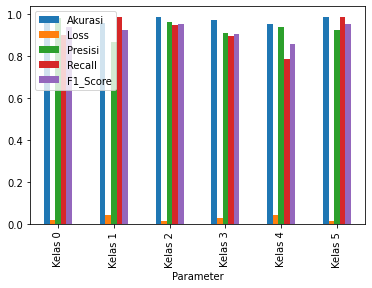

In [ ]:
#Menampilkan Nilai Parameter masing-masing kelas
df1.plot(kind='bar',x='Parameter',y=['Akurasi','Loss','Presisi','Recall','F1_Score'])

In [ ]:
# Mengetahui class berdasarkan gambar masing-masing kelas 
# Angka-angka menunjukan kesesuaian antara masing-masing nomor kelas

Y_test = pd.Index(y_pred_class)
print("Class dan jumlah data Penelitian:\n Class Jumlah \n",Y_test.value_counts())



Class dan jumlah data Penelitian:
 Class Jumlah 
 1    28825
4    19269
0    18796
3    15844
2    15314
5    15106
dtype: int64


In [ ]:
# Menampilkan semua data pertama/awal true atau pun prediksi 
print("Dataset Penelitian:")
print('True:', Y_test.values[0:-1])
print('False:', y_pred_class.transpose()[0:-1])
print("\n")


Dataset Penelitian:
True: [1 1 1 ... 5 5 5]
False: [1 1 1 ... 5 5 5]




# Evaluasi Gambar Pelatihan dengan Gambar Data Pengujian

## Klasifikasi Gambar Data Pengujian dalam Piksel

Pada evaluasi gambar ini, kita mencari akurasi data pengujian dalam piksel. Terdapat 6 jenis gambar yang akan diujikan dalam mendapatkan nilai akurasi piksel, yaitu satu gambar yang akan memiliki fitur berbagai macam kelas. Paling sedikitnya 2 kelas.

**Memuat Model yang sudah dilatih**

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/LCC/resnet/aset/test_chop.h5")

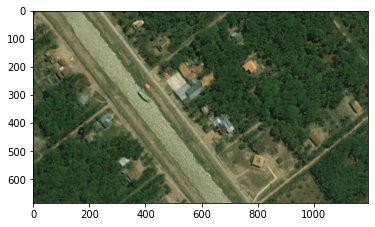

29
1479 29 51


In [ ]:

#Membaca Gambar Test Data dan Menampilkannya
img_path = "/content/drive/MyDrive/LCC/validasi/12.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

(1479, 6)
(51, 29)
(1479, 6)


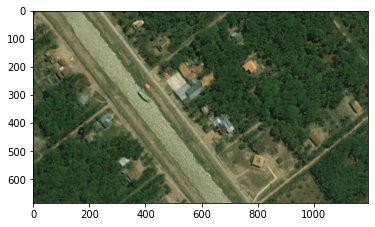

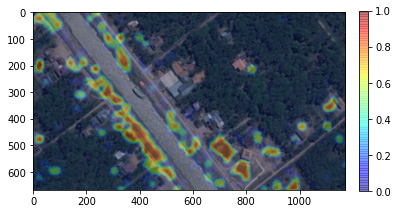

Minimal level zoomed : -0.19922735
Maximal level zoomed : 1.2443215
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (0, 45518)
Akurasi dalam piksel (100%) : 5.8178146448702055
(51, 29)
(1479, 6)


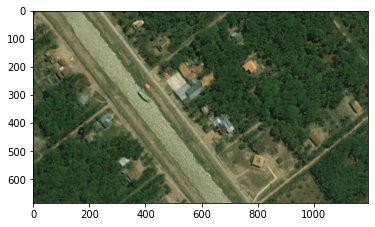

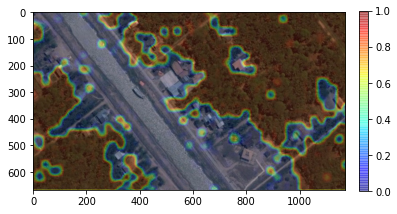

Minimal level zoomed : -0.38059086
Maximal level zoomed : 1.3035297
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (1, 414677)
Akurasi dalam piksel (100%) : 53.00131647899385
(51, 29)
(1479, 6)


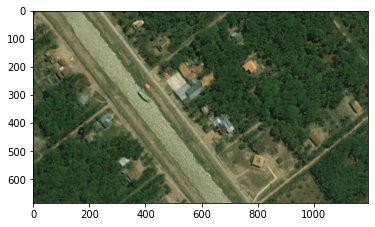

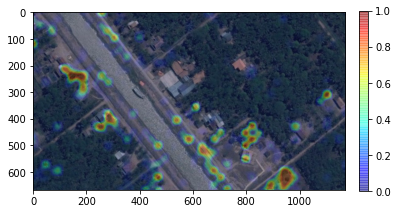

Minimal level zoomed : -0.266793
Maximal level zoomed : 1.1519712
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (2, 27561)
Akurasi dalam piksel (100%) : 3.5226677232582215
(51, 29)
(1479, 6)


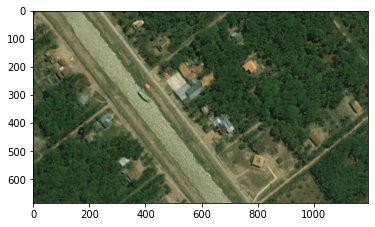

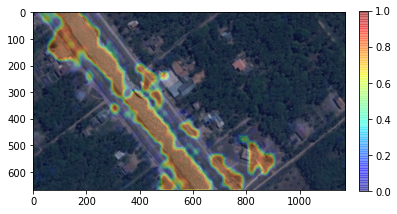

Minimal level zoomed : -0.21680076
Maximal level zoomed : 1.2907922
Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0

Banyaknya piksel yang terlihat dalam kelas  (3, 94710)
Akurasi dalam piksel (100%) : 12.105216068712535
(51, 29)


In [ ]:
#Memprediksi probalititas keberadaaan tutupan terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model.predict(patches)
print(predictions.shape)
#print(predictions)
for i in range(6):
  kelas = np.reshape(predictions[:,i],(n_total//n_x,n_x))
  print(kelas.shape)
  kelas = np.rot90(kelas)
  kelas = np.rot90(kelas)
  kelas = np.rot90(kelas)
  kelas = np.flip(kelas,axis=-1)
#Array pada gambar diperbesar menggunakan  spline
  h_factor = img.shape[0]//kelas.shape[0]
  w_factor = img.shape[1]//kelas.shape[1]
  predictions = model.predict(patches)
  print(predictions.shape)
  from scipy.ndimage import zoom
  zoomed = zoom(kelas,(h_factor,w_factor))
#print(zoomed.shape)

#Menampilkan hasil gambar level tertentu
  plt.imshow(img)
  plt.show()

  plt.imshow(img)
  plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  #Memperoleh Nilai Akurasi data pengujian dalam piksel
  print("Minimal level zoomed :", np.min(zoomed))
  print("Maximal level zoomed :", np.max(zoomed))
  #Menampilkan nilai level zoomed dalam range 0 sampai 1
  normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
  print("Minimal level ternomalisasi:", np.min(normalized))
  print("Maximal level ternomalisasi:", np.max(normalized))
  print('')
  #Menghitung banyaknya piksel
  #Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
  banyakpiksel=(normalized>0.5).sum()
  akurasi=((normalized>0.5).sum()*100/(normalized<1).sum())
  print("Banyaknya piksel yang terlihat dalam kelas ", (i, banyakpiksel))
  print("Akurasi dalam piksel (100%) :", (akurasi))

# Evaluasi Data Pelatihan terhadap Pengujian dalam Luas Lahan

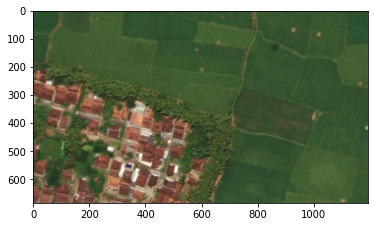

29
1479 29 51


In [ ]:
#Membaca Gambar Test Data dan Menampilkannya
img_path22 = "/content/drive/MyDrive/LCC/validasi/24.jpg"
img22 = load_img(img_path22)
img22 = img_to_array(img22)/255
plt.imshow(img22)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches22 = []
windows22 = sw.generate(img22, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows22):
    _img22 = img22[window.indices()]
    patches22.append(_img22)
patches22 = np.array(patches22)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total22 = len(windows22)
_x = 0
for i,window in enumerate(windows22):
    if _x != window.x:
        n_x22 = i
        print(n_x22)
        break
    _x = window.x


print(n_total22,n_x22,n_total22//n_x22)

(1479, 6)


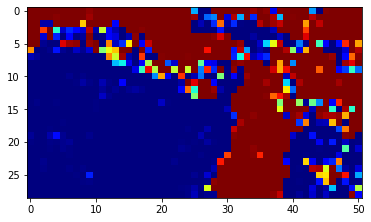

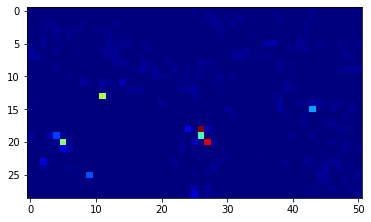

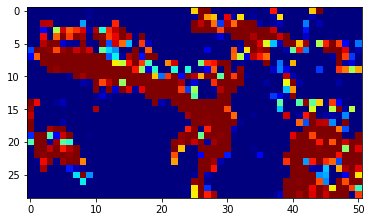

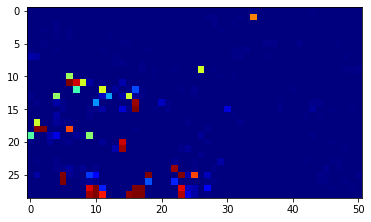

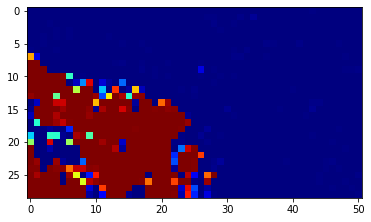

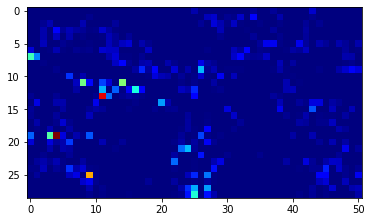

In [ ]:
#Memprediksi probalititas keberadaaan tutupan lahan tertentu terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
from scipy.ndimage import zoom
predictions22 = model.predict(patches22)
print(predictions22.shape)
#print(predictions22)
full_pred={}
for i in range(predictions22.shape[1]) :
  full_pred[f"kelas22_{i}"] = np.reshape(predictions22[:,i],(n_total22//n_x22,n_x22))
  full_pred[f"kelas22_{i}"] = np.rot90(full_pred[f"kelas22_{i}"])
  full_pred[f"kelas22_{i}"] = np.rot90(full_pred[f"kelas22_{i}"])
  full_pred[f"kelas22_{i}"] = np.rot90(full_pred[f"kelas22_{i}"])
  full_pred[f"kelas22_{i}"] = np.flip(full_pred[f"kelas22_{i}"],axis=-1)
plt.imshow(full_pred['kelas22_0'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_1'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_2'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_3'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_4'],cmap="jet")

plt.show()
plt.imshow(full_pred['kelas22_5'],cmap="jet")

plt.show()

In [ ]:
from scipy.ndimage import zoom
h_factor22_0 = img22.shape[0]//full_pred['kelas22_0'].shape[0]
w_factor22_0 = img22.shape[1]//full_pred['kelas22_0'].shape[1]
print(h_factor22_0)

zoomed22_0 = zoom(full_pred['kelas22_0'],(h_factor22_0,w_factor22_0))
print(zoomed22_0.shape)
print("\n")

h_factor22_1 = img22.shape[0]//full_pred['kelas22_1'].shape[0]
w_factor22_1 = img22.shape[1]//full_pred['kelas22_1'].shape[1]
print(h_factor22_1)
zoomed22_1 = zoom(full_pred['kelas22_1'],(h_factor22_1,w_factor22_1))
print(zoomed22_1.shape)
print("\n")
h_factor22_2 = img22.shape[0]//full_pred['kelas22_2'].shape[0]
w_factor22_2 = img22.shape[1]//full_pred['kelas22_2'].shape[1]
print(h_factor22_2)
zoomed22_2 = zoom(full_pred['kelas22_2'],(h_factor22_2,w_factor22_2))
print(zoomed22_2.shape)
print("\n")
h_factor22_3 = img22.shape[0]//full_pred['kelas22_3'].shape[0]
w_factor22_3 = img22.shape[1]//full_pred['kelas22_3'].shape[1]
print(h_factor22_3)

zoomed22_3 = zoom(full_pred['kelas22_3'],(h_factor22_3,w_factor22_3))
print(zoomed22_3.shape)
print("\n")

h_factor22_4 = img22.shape[0]//full_pred['kelas22_4'].shape[0]
w_factor22_4 = img22.shape[1]//full_pred['kelas22_4'].shape[1]
print(h_factor22_4)

zoomed22_4 = zoom(full_pred['kelas22_4'],(h_factor22_4,w_factor22_4))
print(zoomed22_4.shape)
print("\n")
h_factor22_5 = img22.shape[0]//full_pred['kelas22_5'].shape[0]
w_factor22_5 = img22.shape[1]//full_pred['kelas22_5'].shape[1]
print(h_factor22_5)

zoomed22_5 = zoom(full_pred['kelas22_5'],(h_factor22_5,w_factor22_5))
print(zoomed22_5.shape)
print("\n")

23
(667, 1173)


23
(667, 1173)


23
(667, 1173)


23
(667, 1173)


23
(667, 1173)


23
(667, 1173)




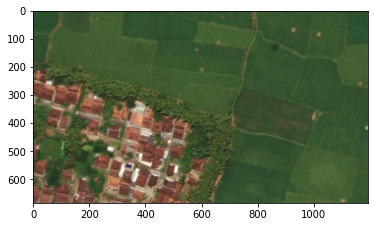

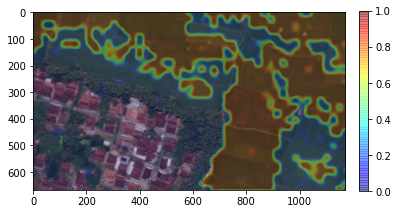

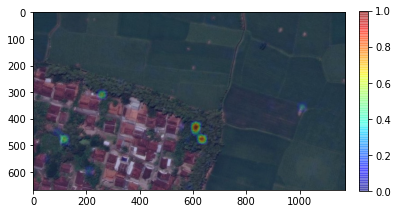

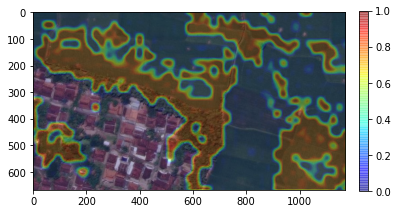

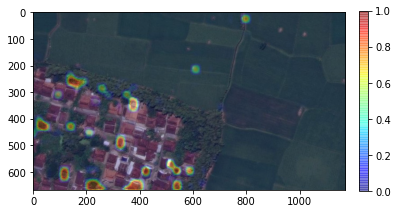

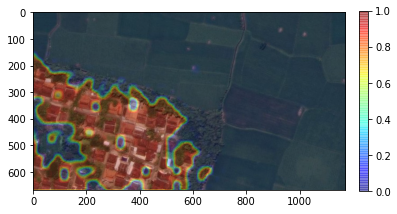

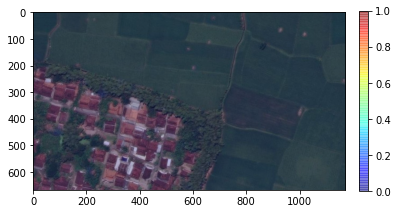

In [ ]:
  plt.imshow(img22)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_0,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_1,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_2,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_3,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_4,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

  plt.imshow(img22)
  plt.imshow(zoomed22_5,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

  plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
  plt.show()

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

##Menampilkan Luas Tutupan Lahan yang berwarna Merah


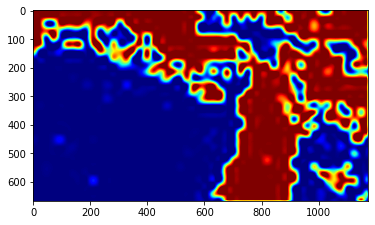

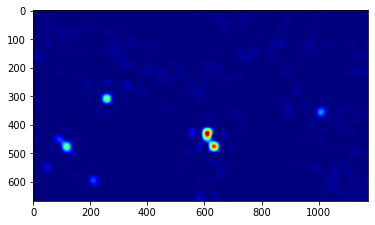

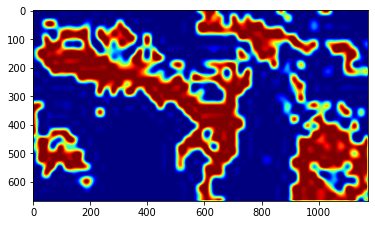

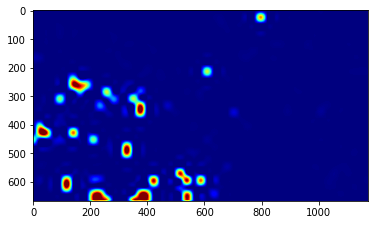

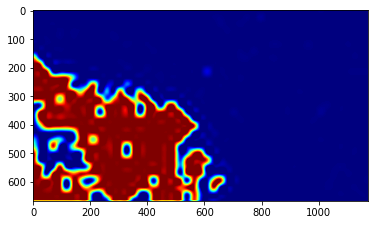

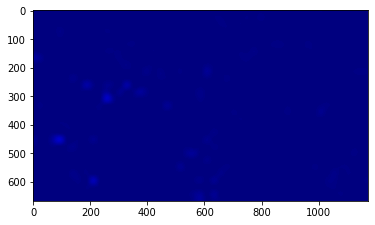

In [ ]:
plt.imshow(zoomed22_0,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_1,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_2,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_3,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_4,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()
plt.imshow(zoomed22_5,alpha=1,vmax=1.0,vmin=0,cmap="jet")
plt.show()

#Menghitung Luas Lahan


In [ ]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas sawah:", np.min(zoomed22_0))
print("Maximal level zoomed kelas sawah:", np.max(zoomed22_0))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas hutan dan sawit:", np.min(zoomed22_1))
print("Maximal level zoomed kelas hutan dan sawit:", np.max(zoomed22_1))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas perkebunan:", np.min(zoomed22_2))
print("Maximal level zoomed kelas perkebunan:", np.max(zoomed22_2))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas tanah lapang:", np.min(zoomed22_3))
print("Maximal level zoomed kelas tanah lapang:", np.max(zoomed22_3))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas permukiman:", np.min(zoomed22_4))
print("Maximal level zoomed kelas permukiman:", np.max(zoomed22_4))
print("\n")
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed kelas perairan:", np.min(zoomed22_5))
print("Maximal level zoomed kelas perairan:", np.max(zoomed22_5))
print("\n")

Minimal level zoomed kelas sawah: -0.306911
Maximal level zoomed kelas sawah: 1.320112


Minimal level zoomed kelas hutan dan sawit: -0.18958524
Maximal level zoomed kelas hutan dan sawit: 1.0164132


Minimal level zoomed kelas perkebunan: -0.34197012
Maximal level zoomed kelas perkebunan: 1.3249584


Minimal level zoomed kelas tanah lapang: -0.22130884
Maximal level zoomed kelas tanah lapang: 1.2658682


Minimal level zoomed kelas permukiman: -0.26901883
Maximal level zoomed kelas permukiman: 1.2876536


Minimal level zoomed kelas perairan: -0.008850517
Maximal level zoomed kelas perairan: 0.06743464




In [ ]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_0 = (zoomed22_0-np.min(zoomed22_0))/(np.max(zoomed22_0)-np.min(zoomed22_0))
print("Minimal level ternomalisasi:", np.min(normalized22_0))
print("Maximal level ternomalisasi:", np.max(normalized22_0))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_1 = (zoomed22_1-np.min(zoomed22_1))/(np.max(zoomed22_1)-np.min(zoomed22_1))
print("Minimal level ternomalisasi:", np.min(normalized22_1))
print("Maximal level ternomalisasi:", np.max(normalized22_1))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_2 = (zoomed22_2-np.min(zoomed22_2))/(np.max(zoomed22_2)-np.min(zoomed22_2))
print("Minimal level ternomalisasi:", np.min(normalized22_2))
print("Maximal level ternomalisasi:", np.max(normalized22_2))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_3 = (zoomed22_3-np.min(zoomed22_3))/(np.max(zoomed22_3)-np.min(zoomed22_3))
print("Minimal level ternomalisasi:", np.min(normalized22_3))
print("Maximal level ternomalisasi:", np.max(normalized22_3))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_4 = (zoomed22_4-np.min(zoomed22_4))/(np.max(zoomed22_4)-np.min(zoomed22_4))
print("Minimal level ternomalisasi:", np.min(normalized22_4))
print("Maximal level ternomalisasi:", np.max(normalized22_4))
print("\n")
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized22_5 = (zoomed22_5-np.min(zoomed22_5))/(np.max(zoomed22_5)-np.min(zoomed22_5))
print("Minimal level ternomalisasi:", np.min(normalized22_5))
print("Maximal level ternomalisasi:", np.max(normalized22_5))
print("\n")

Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0




In [ ]:
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_0=(normalized22_0>0.5).sum()
akurasi22_0=((normalized22_0>0.5).sum()*100/(normalized22_0<1).sum())
print("Luas tutupan lahan dalam piksel :", (luaspiksel22_0))
print("Persentase tutupan lahan dalam piksel (100%) :", (akurasi22_0))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_1=(normalized22_1>0.5).sum()
akurasi22_1=((normalized22_1>0.5).sum()*100/(normalized22_1<1).sum())
print("Luas tutupan lahan dalam piksel :", (luaspiksel22_1))
print("Persentase tutupan lahan dalam piksel (100%) :", (akurasi22_1))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_2=(normalized22_2>0.5).sum()
akurasi22_2=((normalized22_2>0.5).sum()*100/(normalized22_2<1).sum())
print("Luas tutupan lahan dalam piksel :", (luaspiksel22_2))
print("Persentase tutupan lahan dalam piksel (100%) :", (akurasi22_2))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_3=(normalized22_3>0.5).sum()
akurasi22_3=((normalized22_3>0.5).sum()*100/(normalized22_3<1).sum())
print("Luas tutupan lahan dalam piksel :", (luaspiksel22_3))
print("Persentase tutupan lahan dalam piksel (100%) :", (akurasi22_3))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_4=(normalized22_4>0.5).sum()
akurasi22_4=((normalized22_4>0.5).sum()*100/(normalized22_4<1).sum())
print("Luas tutupan lahan dalam piksel :", (luaspiksel22_4))
print("Persentase tutupan lahan dalam piksel (100%) :", (akurasi22_4))
print("\n")
#Menghitung luas tutupan lahan dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sesuai dengan kelasnya.
luaspiksel22_5=(normalized22_5>0.5).sum()
akurasi22_5=((normalized22_5>0.5).sum()*100/(normalized22_5<1).sum())
print("Luas tutupan lahan dalam piksel :", (luaspiksel22_5))
print("Persentase tutupan lahan dalam piksel (100%) :", (akurasi22_5))
print("\n")

Luas tutupan lahan dalam piksel : 312720
Persentase tutupan lahan dalam piksel (100%) : 39.969836015286496


Luas tutupan lahan dalam piksel : 2084
Persentase tutupan lahan dalam piksel (100%) : 0.26636332263960427


Luas tutupan lahan dalam piksel : 262324
Persentase tutupan lahan dalam piksel (100%) : 33.52854714400746


Luas tutupan lahan dalam piksel : 13977
Persentase tutupan lahan dalam piksel (100%) : 1.786449213307941


Luas tutupan lahan dalam piksel : 181204
Persentase tutupan lahan dalam piksel (100%) : 23.160316466212503


Luas tutupan lahan dalam piksel : 2425
Persentase tutupan lahan dalam piksel (100%) : 0.3099477242807296




"Validitas Pengukuran di Lapangan"

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/Validitas%20Pengukuran.jpg)

Untuk validasi/keakuratan perhitungan konversi nilai piksel pada meter, saya memiliki pengukuran secara langsung di lapangan. Objek yang digunakan sebagai pengukuran tersebut dilakukan pada **lebar jalan di depan rumah**. **Lokasi terletak di Dusun II RT 02/RW 07, Sokaraja Tengah, Kecamatan Sokaraja, Kabupaten Banyumas, Provinsi Jawa Tengah.**

Dengan menggunakan **alat ukur meteran**, diperoleh lebar jalan sebesar **2,71 meter.** Dapat dilihat lebih detail pada gambar.




**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/New%20Gambar%20100m.jpg)

Dapat dilakukan dengan langkah-langkah sbb :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek lebar jalan. Dimana didapatkan lebarnya sebesar 2,71 meter melalui fitur pengukuran pada Google Earth. Begitu pula dengan validitas pengukuran di lapangan pada lokasi yang sama diperoleh lebar sebesar 2,71 meter.[Resolusi Gambar adalah 1116x632 piksel]
3.   Pada ketinggian 100 meter, dapat dikalkulasi nilai lebar jalan dalam piksel, disini berjumlah 40 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,71 meter / 40 piksel
                           = 0,06775 m/p 
                           ~= 0,068 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,068

Untuk menghitung luas maka dilakukan dengan 0,068 x 0,068 = 0,004624 (m/p)^2

In [ ]:
#Setelah diketahui luas tutupan lahan dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.004624*(luaspiksel22)
luasha = (luasmtr)/10000
print("Luas tutupan lahan dalam meter persegi :", (luasmtr))
print("Luas tutupan lahan dalam hektar :", (luasha))

Luas tutupan lahan dalam meter persegi : 3359.9833599999997
Luas tutupan lahan dalam hektar : 0.33599833599999995


# Perbandingan Hasil Luas Lahan dengan Fitur pada Google Earth

![image](https://raw.githubusercontent.com/Gio1709/paddy_100m/master/Perbandingan%20Google.jpg)

Hasil yang diperoleh pada fitur pengukuran luas lahan dalam hektar pada Google Earth didapatkan hasil sebesar 0,20 Hektar. Akan tetapi perlu diperhatikan dataset pengujian/testing yang digunakan dalam pengukuran lahan sawah mesti pada ketinggian yang sama dengan dataset pelatihan/training. 

Pada bagian ini diketahui ketinggiannya adalah 100 meter.